In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Parameters

In [2]:
# Parameters:
w = 25  # window size
feature_columns = ["temp", "humidity", "light", "co2"]
d = len(feature_columns) # Input feature size
z = 3 # Latent feature size
lr = 0.0001 # Learning rate
beta = 10 # Weighting parameter
n_c = 100 # Epochs
epsilon = 1.0e-03 # Convergence threshold MDD Loss
batch_size = 64
gamma = 1 # RBF kernel parameter
cp_threshold = 0.40 # % Probability threshold for identifying a segment as change point
ma_window_size = 10  # Moving average filter window size

# Read Data

In [3]:
df = pd.read_parquet("data/processed/data_train.parquet")

# Create Segment Tensors

In [4]:
def create_segments(df, feature_columns, window_size):
    """Given dataset and features, partition data into non-overlapping consecutive segments of window_size and return segment tensors"""
    df_features = df[feature_columns]
    num_segments = len(df_features) - window_size
    
    # Initialize tensors for X_L and X_R:
    X_L = torch.zeros((num_segments, window_size, len(feature_columns)))
    X_R = torch.zeros((num_segments, window_size, len(feature_columns)))
    
    # Create the segments:
    for start in range(num_segments):
        end = start + window_size
        X_L[start] = torch.tensor(df_features.iloc[start:end].values)
        X_R[start] = torch.tensor(df_features.iloc[start+1:end+1].values)
    
    return X_L, X_R

In [5]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_columns])
scaled_features = pd.DataFrame(scaled_features, columns = feature_columns)

X_L, X_R = create_segments(scaled_features, feature_columns, w)
print(X_L.shape, X_R.shape)

torch.Size([8118, 25, 4]) torch.Size([8118, 25, 4])


# Data Loader

In [6]:
dataset_L = TensorDataset(X_L)
dataset_R = TensorDataset(X_R)

loader_L = DataLoader(dataset_L, batch_size = batch_size, shuffle = True)
loader_R = DataLoader(dataset_R, batch_size = batch_size, shuffle = True)

# MMD Loss Definition

In [7]:
def rbf_kernel(X, Y, gamma):
    """
    Radian Basis Function (RBF) kernel implemented for PyTorch tensors.
    k(x, y) = exp(-gamma * ||x - y||^2)
    """
    X_norm = torch.sum(X ** 2, dim=1).view(-1, 1)
    Y_norm = torch.sum(Y ** 2, dim=1).view(1, -1)
    squared_dist = X_norm + Y_norm - 2 * torch.mm(X, Y.t())

    return torch.exp(-gamma * squared_dist)

def flatten_samples(samples):
    """
    Flatten each sample in the given tensor.
    For an input of shape (n_samples, height, width), the output will be of shape (n_samples, height*width).
    """
    return samples.view(-1, samples.shape[-1])

def mmd_loss(samples_p, samples_q, gamma, sample_size = 1000):
    """
    Optimized calculation of the MMD squared using vectorized operations and sampling. It was implemented to reduce impact on memory by using a random sample to calculate MMD Loss.
    """
    # Sample a subset of data for efficiency
    indices_p = torch.randperm(len(samples_p))[:sample_size]
    indices_q = torch.randperm(len(samples_q))[:sample_size]
    samples_p_sampled = samples_p[indices_p]
    samples_q_sampled = samples_q[indices_q]

    # Flatten the samples
    samples_p_flat = flatten_samples(samples_p_sampled)
    samples_q_flat = flatten_samples(samples_q_sampled)

    # Compute the RBF kernel matrices
    K_pp = rbf_kernel(samples_p_flat, samples_p_flat, gamma)
    K_pq = rbf_kernel(samples_p_flat, samples_q_flat, gamma)
    K_qq = rbf_kernel(samples_q_flat, samples_q_flat, gamma)

    # Compute the MMD squared
    mmd_sq = torch.mean(K_pp) - 2 * torch.mean(K_pq) + torch.mean(K_qq)
    
    return mmd_sq

def median_heuristic(samples_p, samples_q, sample_size=1000):
    """Estimate the gamma parameter using the median heuristic based on two sets of samples."""
    # Sample a subset of data for efficiency
    indices_p = torch.randperm(len(samples_p))[:sample_size]
    indices_q = torch.randperm(len(samples_q))[:sample_size]
    samples_p_sampled = samples_p[indices_p]
    samples_q_sampled = samples_q[indices_q]

    # Combine the samples
    combined_samples = torch.cat([samples_p_sampled, samples_q_sampled], dim=0)
    
    # Flatten the combined samples
    combined_samples_flat = flatten_samples(combined_samples)

    # Compute pairwise distances
    distances = torch.cdist(combined_samples_flat, combined_samples_flat, p=2)

    # Calculate the median distance
    median_dist = torch.median(distances)
    gamma = 1 / (2 * median_dist ** 2)

    return gamma.item()

In [8]:
gamma = median_heuristic(X_L, X_R, sample_size=1000)

# Auto Encoder Definition

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 40),
            nn.ReLU(True),
            nn.Linear(40, 30),
            nn.ReLU(True),
            nn.Linear(30, 20),
            nn.ReLU(True),
            nn.Linear(20, latent_dim)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.ReLU(True),
            nn.Linear(20, 30),
            nn.ReLU(True),
            nn.Linear(30, 40),
            nn.ReLU(True),
            nn.Linear(40, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

# Model Training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = AutoEncoder(input_dim = d, latent_dim = z).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr = lr)
mse_loss = nn.MSELoss()

In [11]:
mmd_losses = []
epoch_losses = []

for epoch in range(n_c):
    # Turn on training mode:
    autoencoder.train()

    for (X_L_batch,), (X_R_batch,) in zip(loader_L, loader_R):
        
        optimizer.zero_grad()
        
        # Move data to device:
        X_L_batch = X_L_batch.to(device)
        X_R_batch = X_R_batch.to(device)
        
        # Forward pass:
        X_L_hat_batch, z_L_batch = autoencoder(X_L_batch)
        X_R_hat_batch, z_R_batch = autoencoder(X_R_batch)

        # Calculate the reconstruction loss for the minibatch:
        loss_X_L_batch = mse_loss(X_L_hat_batch, X_L_batch)
        loss_X_R_batch = mse_loss(X_R_hat_batch, X_R_batch)

        # Calculate the MMD loss for the minibatch:
        mmd_loss_val_batch = mmd_loss(z_L_batch, z_R_batch, gamma)

        # Combine the losses:
        loss_batch = loss_X_L_batch + loss_X_R_batch + beta * mmd_loss_val_batch

        # Backward pass and optimization:
        loss_batch.backward()
        optimizer.step()

    # Turn off training mode:
    autoencoder.eval()

    # Calculate the MMD on the entire dataset after each epoch for stopping criteria:
    with torch.no_grad():
        # Forward pass:
        X_L_hat, z_L = autoencoder(X_L.to(device))
        X_R_hat, z_R = autoencoder(X_R.to(device))

        # Calculate the reconstruction loss:
        loss_X_L = mse_loss(X_L_hat, X_L.to(device))
        loss_X_R = mse_loss(X_R_hat, X_R.to(device))

        # Calculate the MMD loss:
        mmd_loss_val = mmd_loss(z_L, z_R, gamma)
        mmd_losses.append(mmd_loss_val.cpu())

        # Combine the losses:
        loss = loss_X_L + loss_X_R + beta * mmd_loss_val
        epoch_losses.append(loss.cpu())

    # Logging:
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss X_L: {loss_X_L}, Loss X_R: {loss_X_R}, MMD Loss: {mmd_loss_val}, Total Loss: {loss}")

    # Check for convergence based on MMD
    if mmd_loss_val > epsilon:
        print(f"Convergence reached at epoch {epoch} with MMD Score: {mmd_loss_val}")
        #break  # Break the loop if convergence is reached

Epoch 0, Loss X_L: 0.12226656824350357, Loss X_R: 0.12226125597953796, MMD Loss: 7.748603820800781e-07, Total Loss: 0.24453556537628174
Epoch 10, Loss X_L: 0.04136817529797554, Loss X_R: 0.04136456176638603, MMD Loss: 1.0907649993896484e-05, Total Loss: 0.08284181356430054
Epoch 20, Loss X_L: 0.029756829142570496, Loss X_R: 0.029752537608146667, MMD Loss: 3.510713577270508e-05, Total Loss: 0.059860438108444214
Epoch 30, Loss X_L: 0.022021016106009483, Loss X_R: 0.022017301991581917, MMD Loss: 0.00011897087097167969, Total Loss: 0.0452280268073082
Epoch 40, Loss X_L: 0.021077947691082954, Loss X_R: 0.0210761446505785, MMD Loss: 4.947185516357422e-06, Total Loss: 0.04220356419682503
Epoch 50, Loss X_L: 0.020221160724759102, Loss X_R: 0.02022108994424343, MMD Loss: 6.377696990966797e-06, Total Loss: 0.0405060276389122
Epoch 60, Loss X_L: 0.01855541206896305, Loss X_R: 0.01855631172657013, MMD Loss: 1.430511474609375e-06, Total Loss: 0.037126027047634125
Epoch 70, Loss X_L: 0.0069626970216

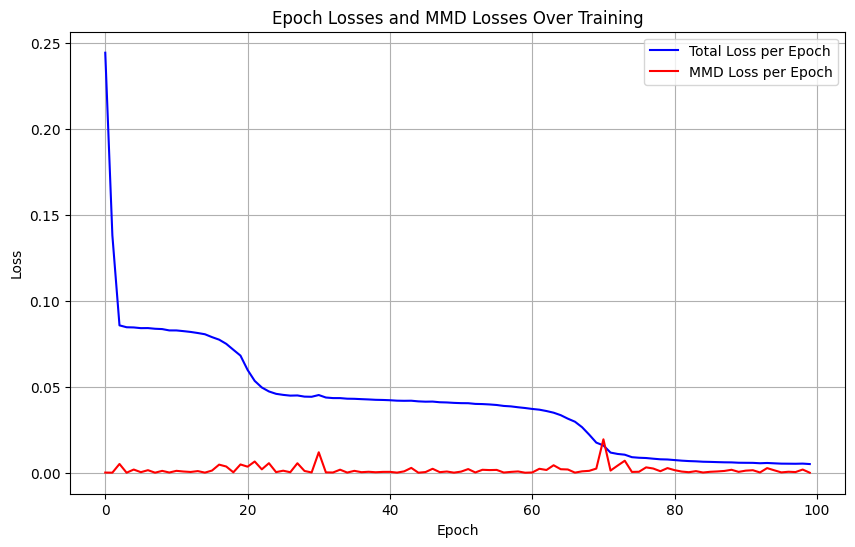

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Total Loss per Epoch', color='blue')
plt.plot(np.array(mmd_losses) * 100, label='MMD Loss per Epoch', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses and MMD Losses Over Training')
plt.legend()
plt.grid(True)
plt.show()

# Flag Change Points

## Calculate MMD Score of Time Window

In [13]:
# Function to flatten the samples remains the same
def flatten_samples(samples):
    return samples.view(-1, samples.shape[-1])

def mmd_loss_full(samples_p, samples_q, gamma):
    """
    Calculation of the MMD using the full dataset (without subsampling).
    """
    # Flatten the samples
    samples_p_flat = flatten_samples(samples_p)
    samples_q_flat = flatten_samples(samples_q)

    # Compute the RBF kernel matrices
    K_pp = rbf_kernel(samples_p_flat, samples_p_flat, gamma)
    K_pq = rbf_kernel(samples_p_flat, samples_q_flat, gamma)
    K_qq = rbf_kernel(samples_q_flat, samples_q_flat, gamma)

    # Compute the MMD squared
    mmd_sq = torch.mean(K_pp) - 2 * torch.mean(K_pq) + torch.mean(K_qq)
    
    return mmd_sq

def compute_window_mmd_scores(model, X_L, X_R, gamma, device):
    model.eval()
    mmd_scores = []
    with torch.no_grad():
        for i in range(X_L.shape[0]):
            # Get the latent representation for each window
            z_L = model(X_L[i].unsqueeze(0).to(device))[1]
            z_R = model(X_R[i].unsqueeze(0).to(device))[1]

            # Compute MMD for the pair of windows
            score = mmd_loss_full(z_L, z_R, gamma)
            mmd_scores.append(score)

    return mmd_scores

In [14]:
# Compute MMD Scores:
window_mmd_scores = compute_window_mmd_scores(autoencoder, X_L, X_R, gamma = gamma, device = device)
window_mmd_scores = [i.item() for i in window_mmd_scores]
# Convert non negative values from numerical instability to zero:
window_mmd_scores = [max(0, score) for score in window_mmd_scores]

## Apply Smoothing Finter to MMD Scores

In [15]:
def moving_average(data, window_size):
    """
    Apply a simple moving average filter to the data.

    Args:
    data (list or np.array): The data to be smoothed.
    window_size (int): The number of points to include in the moving average window.

    Returns:
    np.array: Smoothed data.
    """
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

In [16]:
# Apply MA Filter:
window_mmd_scores = moving_average(window_mmd_scores, ma_window_size)

## Convert MMD Scores to Change Point Probabilities

In [17]:
# Compute Change Point Probabilities:
max_mmd_score = max(window_mmd_scores)
mmd_probabilities = (window_mmd_scores / max_mmd_score)

## Get Change Point Flags

In [18]:
# Flagging change points
predicted_change_points = [score > cp_threshold for score in mmd_probabilities]

## Model Evaluation

## Calculate True Change Points from Occupacy:

In [19]:
true_change_points = [False] * len(predicted_change_points)  # Initialize the list with False

for i in range(1, len(df["occupancy"]) - w):
    # Check for a change in occupancy status between the start and end of a window
    if df["occupancy"][i - 1] != df["occupancy"][i + w]:
        true_change_points[i - 1] = True

## Plot Results

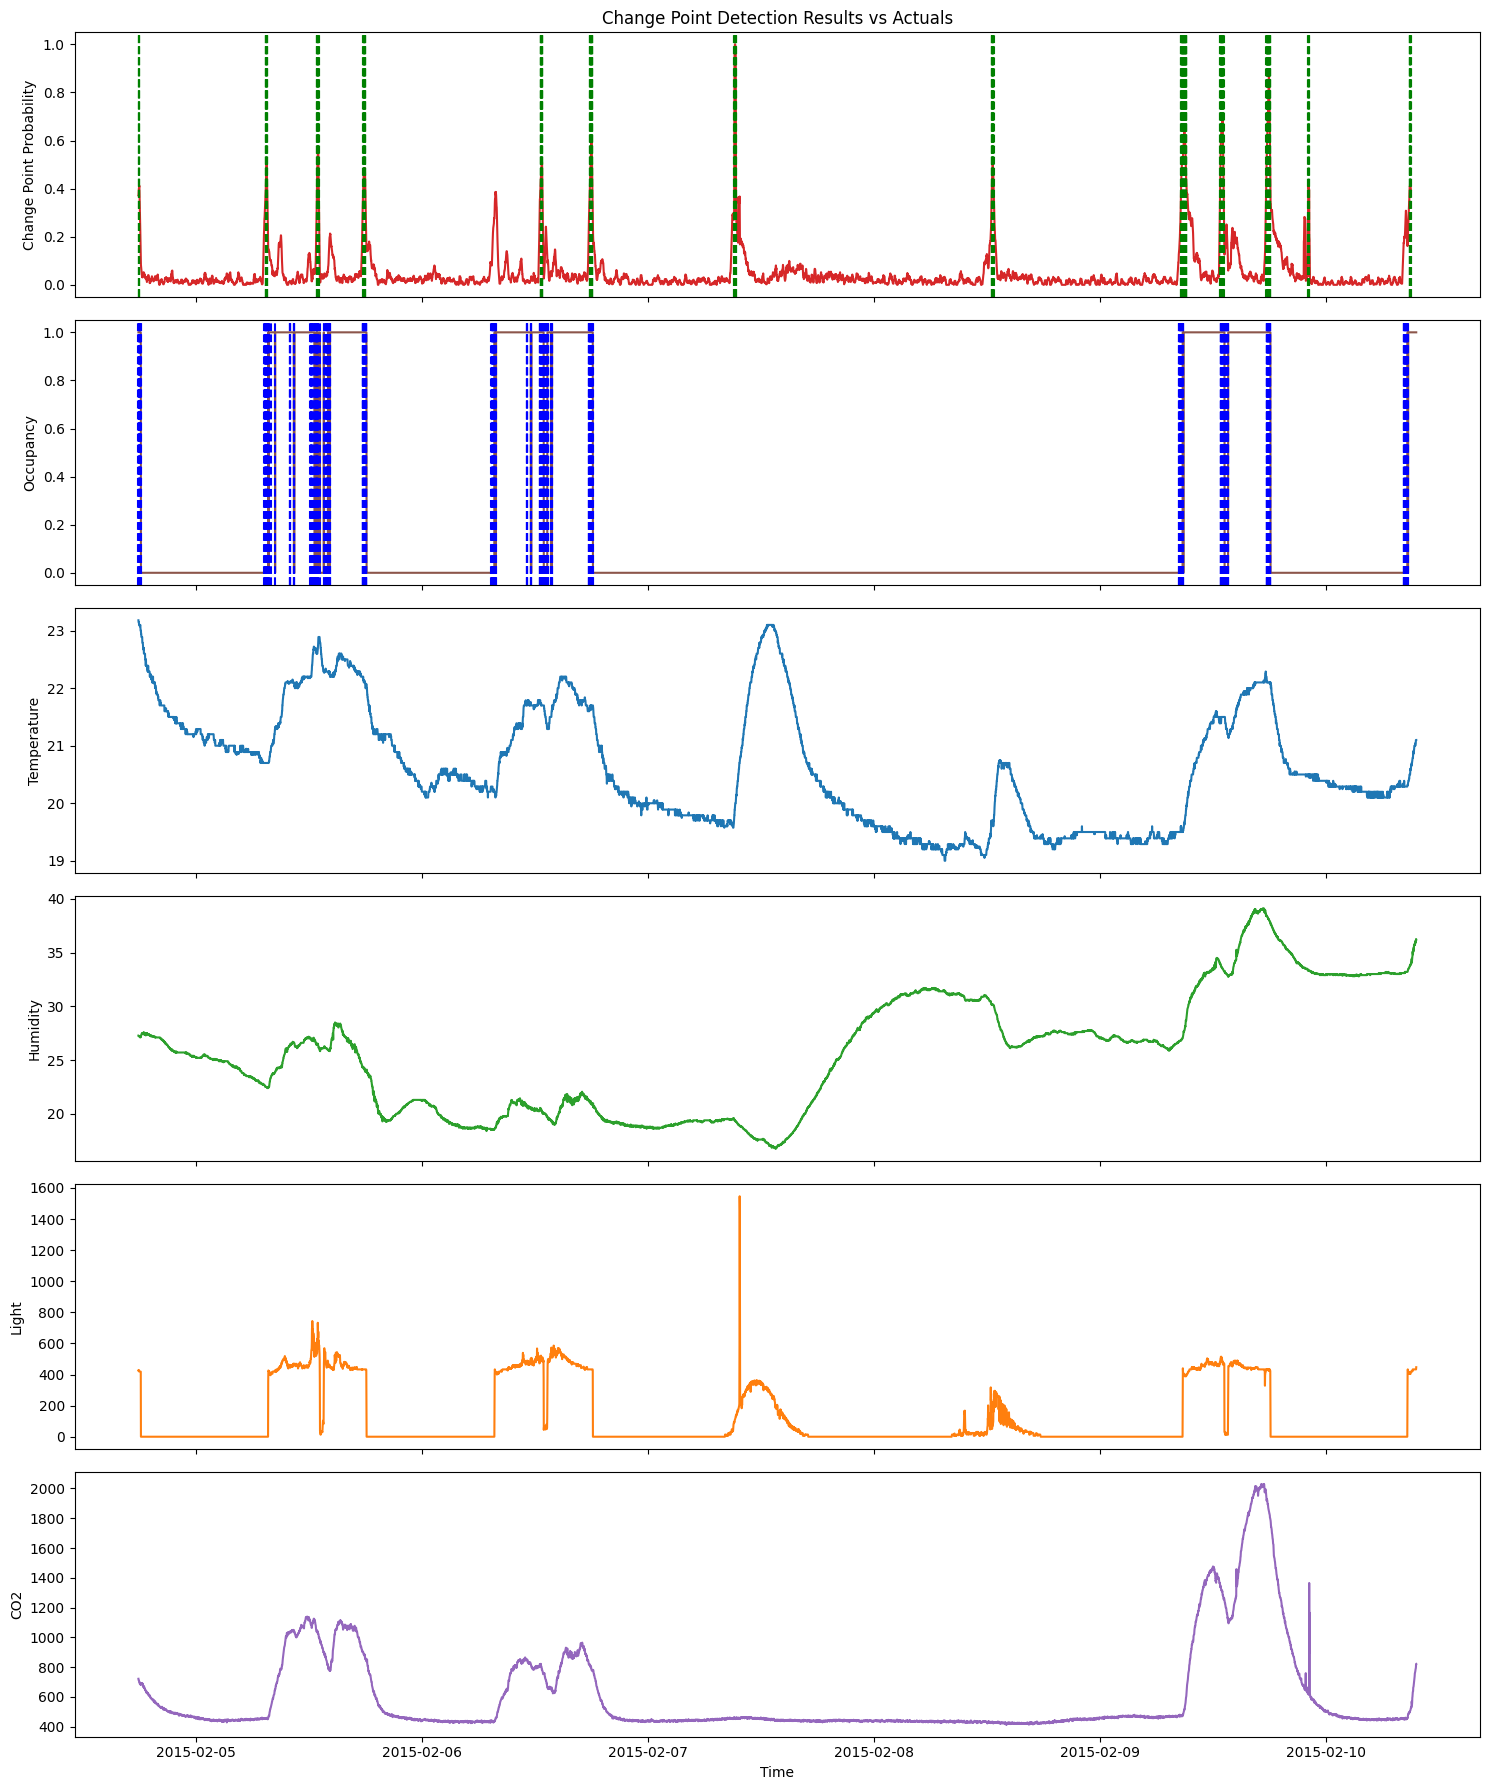

In [20]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 18), sharex=True)

# Plotting Change Point Probabilities:
axes[0].plot(df['dtm'][:len(mmd_probabilities)], mmd_probabilities, color='tab:red')
for i, is_change_point in enumerate(predicted_change_points):
    if is_change_point:
        axes[0].axvline(x=df['dtm'][i], color='green', linestyle='--')
axes[0].set_ylabel('Change Point Probability')
axes[0].set_title('Change Point Detection Results vs Actuals')

axes[1].plot(df['dtm'], df['occupancy'], label='Occupancy', color='tab:brown')
for i, is_occupancy_change in enumerate(true_change_points):
    if is_occupancy_change:
        axes[1].axvline(x=df['dtm'][i], color='blue', linestyle='--')
axes[1].set_ylabel('Occupancy')

# Plotting each sensor reading in separate subplots
axes[2].plot(df['dtm'], df['temp'], label='Temperature', color='tab:blue')
axes[2].set_ylabel('Temperature')

axes[3].plot(df['dtm'], df['humidity'], label='Humidity', color='tab:green')
axes[3].set_ylabel('Humidity')

axes[4].plot(df['dtm'], df['light'], label='Light', color='tab:orange')
axes[4].set_ylabel('Light')

axes[5].plot(df['dtm'], df['co2'], label='CO2', color='tab:purple')
axes[5].set_ylabel('CO2')
axes[5].set_xlabel('Time')


# Adjust layout
plt.tight_layout()
plt.show()


## Confusion Matrix

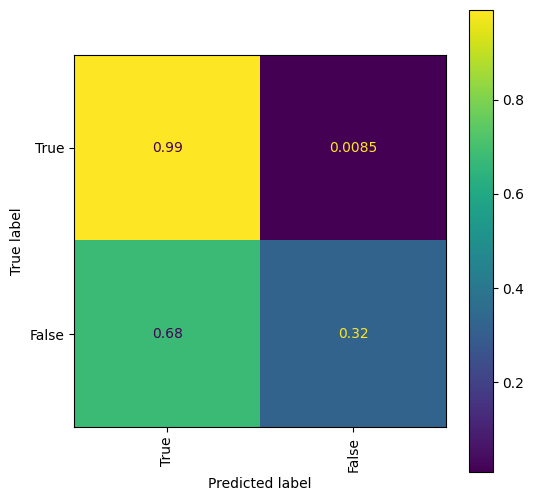

              precision    recall  f1-score   support

        True       0.97      0.99      0.98      7737
       False       0.65      0.32      0.43       372

    accuracy                           0.96      8109
   macro avg       0.81      0.66      0.70      8109
weighted avg       0.95      0.96      0.95      8109



In [21]:
fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(true_change_points, predicted_change_points, display_labels = ["True", "False"], ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()

print(classification_report(true_change_points, predicted_change_points, target_names = ["True", "False"]))

## ROC

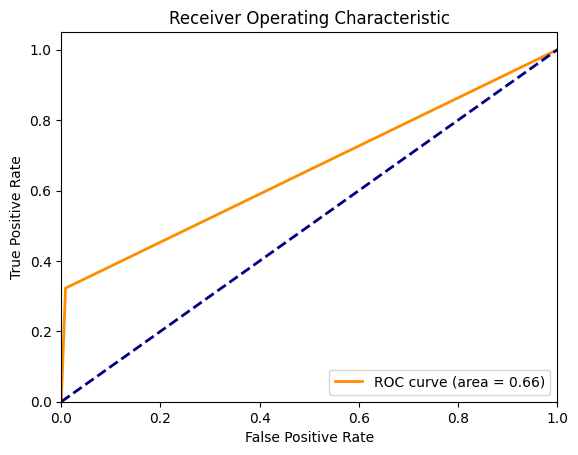

AUC: 0.6570251035034834


In [22]:
fpr, tpr, thresholds = roc_curve(true_change_points, predicted_change_points)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print("AUC:", roc_auc)  # Display the AUC value

# Test Data Evaluation

torch.Size([2640, 25, 4]) torch.Size([2640, 25, 4])


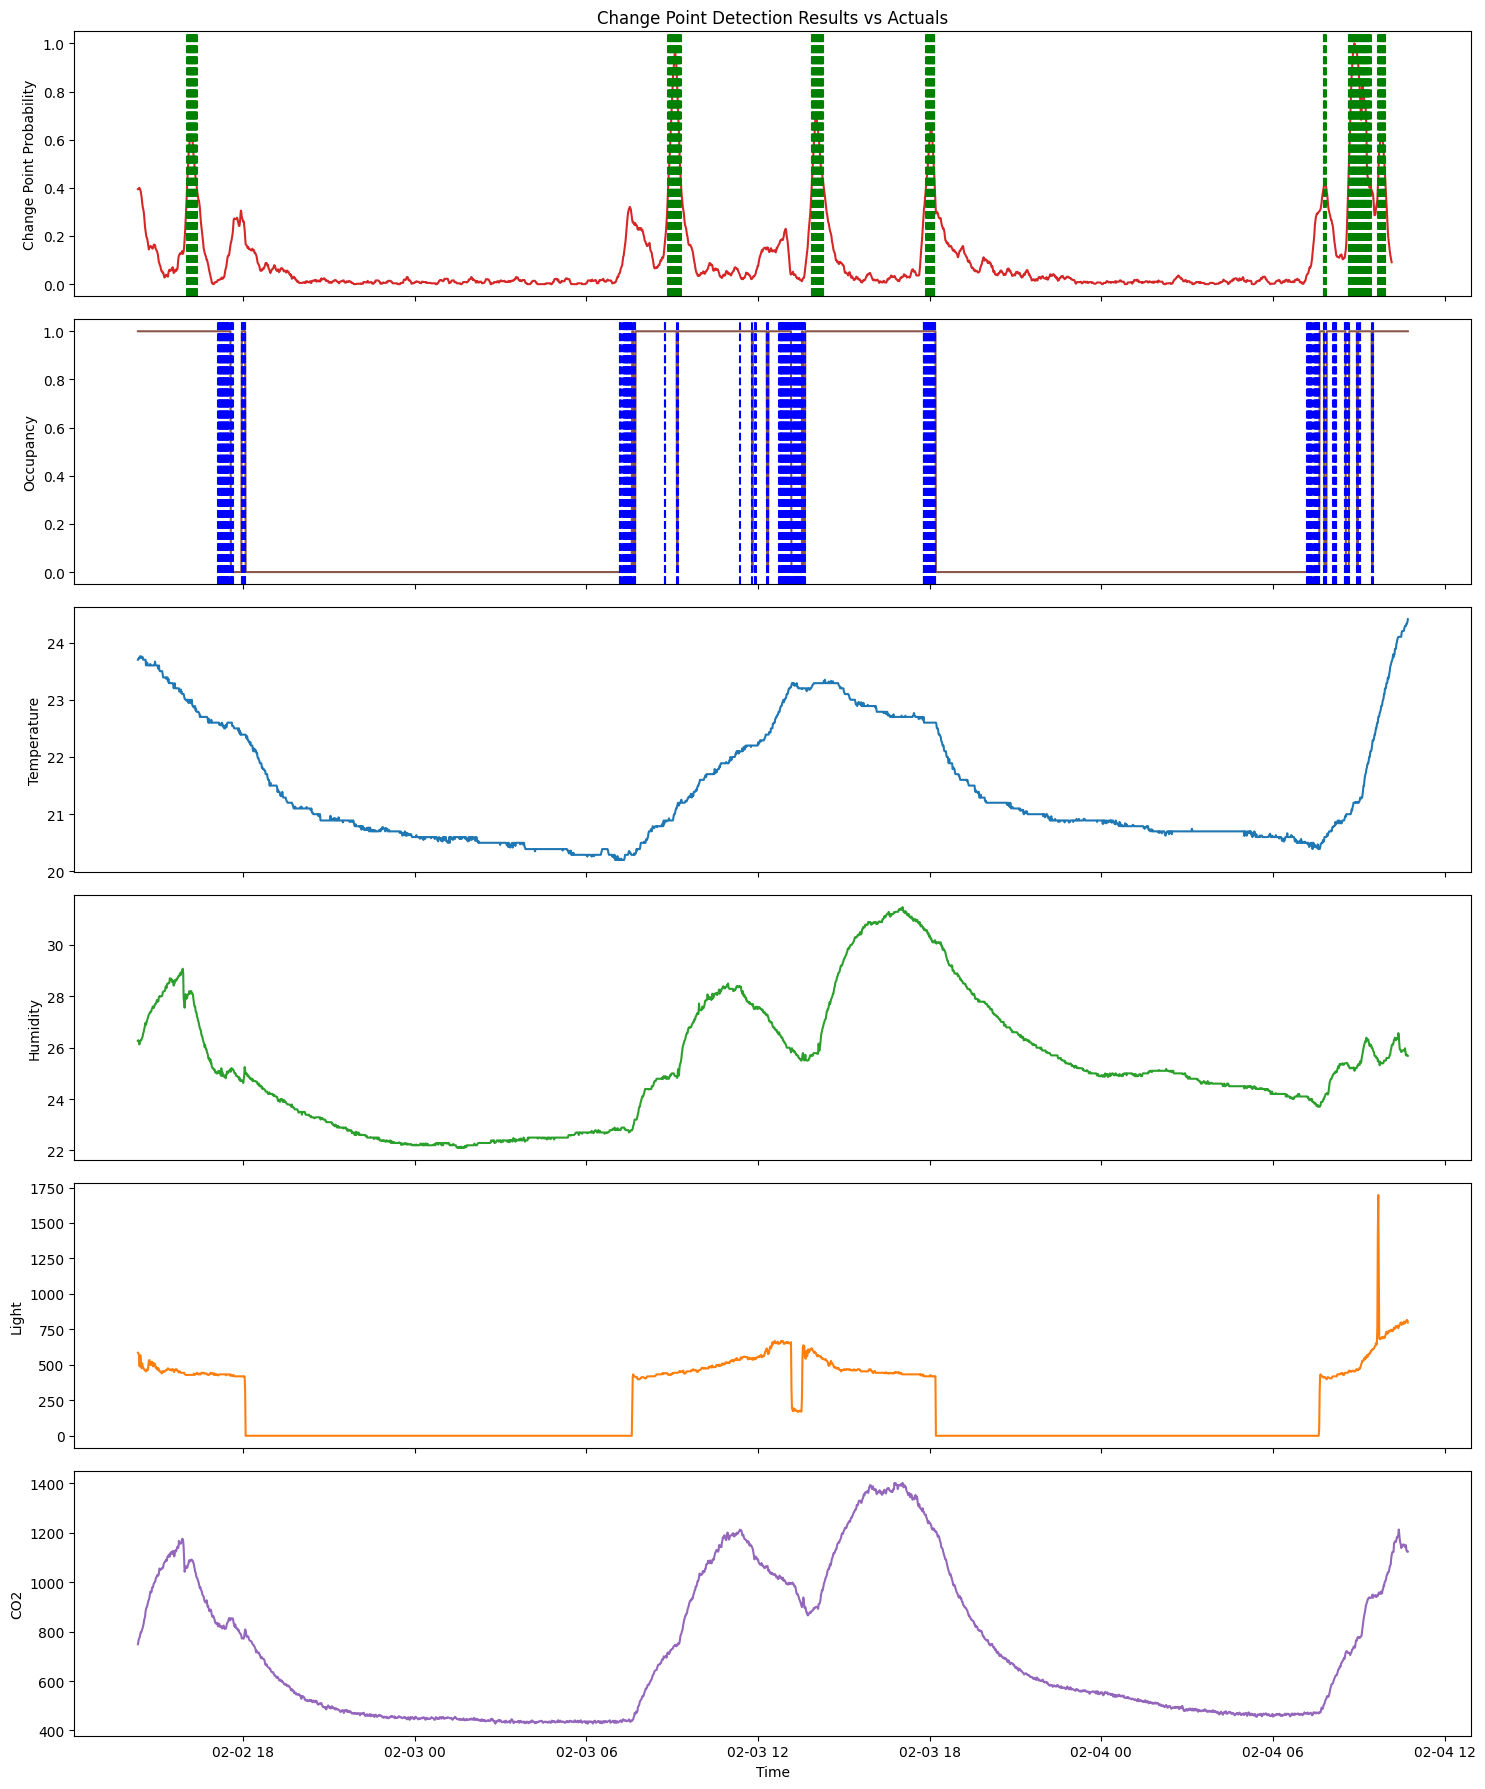

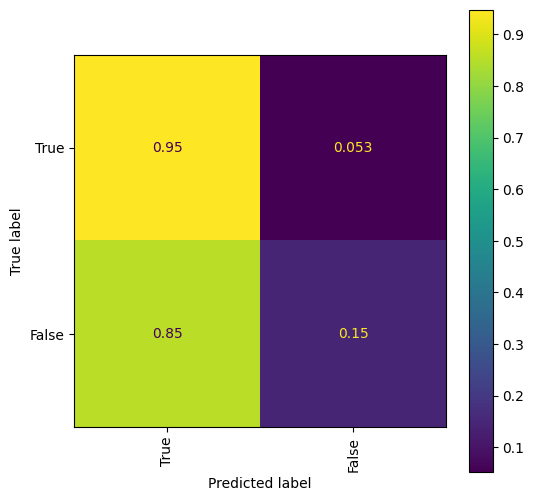

              precision    recall  f1-score   support

        True       0.93      0.95      0.94      2433
       False       0.18      0.15      0.16       198

    accuracy                           0.89      2631
   macro avg       0.56      0.55      0.55      2631
weighted avg       0.88      0.89      0.88      2631



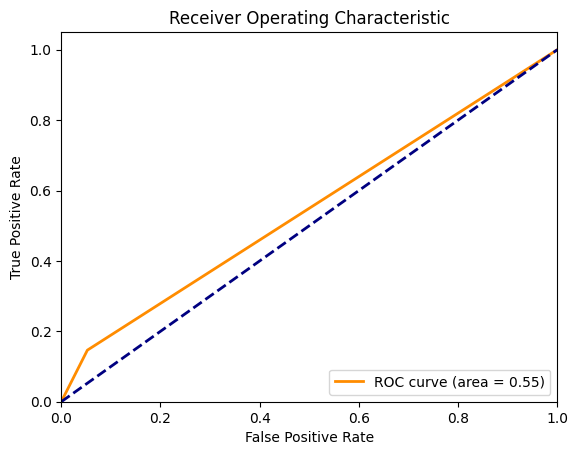

AUC: 0.5469273499483117


In [23]:
df = pd.read_parquet("data/processed/data_test.parquet")

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_columns])
scaled_features = pd.DataFrame(scaled_features, columns = feature_columns)

X_L, X_R = create_segments(scaled_features, feature_columns, w)
print(X_L.shape, X_R.shape)

# Compute MMD Scores:
window_mmd_scores = compute_window_mmd_scores(autoencoder, X_L, X_R, gamma = gamma, device = device)
window_mmd_scores = [i.item() for i in window_mmd_scores]
# Convert non negative values from numerical instability to zero:
window_mmd_scores = [max(0, score) for score in window_mmd_scores]

window_mmd_scores = moving_average(window_mmd_scores, ma_window_size)
# Compute Change Point Probabilities:
max_mmd_score = max(window_mmd_scores)
mmd_probabilities = (window_mmd_scores / max_mmd_score)

# Flagging change points
predicted_change_points = [score > cp_threshold for score in mmd_probabilities]

# Calculate True Change Points from Occupancy:
true_change_points = [False] * len(predicted_change_points)  # Initialize the list with False

for i in range(1, len(df["occupancy"]) - w):
    # Check for a change in occupancy status between the start and end of a window
    if df["occupancy"][i - 1] != df["occupancy"][i + w]:
        true_change_points[i - 1] = True

# Plot Results:
# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 18), sharex=True)

# Plotting Change Point Probabilities:
axes[0].plot(df['dtm'][:len(mmd_probabilities)], mmd_probabilities, color='tab:red')
for i, is_change_point in enumerate(predicted_change_points):
    if is_change_point:
        axes[0].axvline(x=df['dtm'][i], color='green', linestyle='--')
axes[0].set_ylabel('Change Point Probability')
axes[0].set_title('Change Point Detection Results vs Actuals')

axes[1].plot(df['dtm'], df['occupancy'], label='Occupancy', color='tab:brown')
for i, is_occupancy_change in enumerate(true_change_points):
    if is_occupancy_change:
        axes[1].axvline(x=df['dtm'][i], color='blue', linestyle='--')
axes[1].set_ylabel('Occupancy')

# Plotting each sensor reading in separate subplots
axes[2].plot(df['dtm'], df['temp'], label='Temperature', color='tab:blue')
axes[2].set_ylabel('Temperature')

axes[3].plot(df['dtm'], df['humidity'], label='Humidity', color='tab:green')
axes[3].set_ylabel('Humidity')

axes[4].plot(df['dtm'], df['light'], label='Light', color='tab:orange')
axes[4].set_ylabel('Light')

axes[5].plot(df['dtm'], df['co2'], label='CO2', color='tab:purple')
axes[5].set_ylabel('CO2')
axes[5].set_xlabel('Time')


# Adjust layout
plt.tight_layout()
plt.show()

# Confusion Matrix:

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(true_change_points, predicted_change_points, display_labels = ["True", "False"], ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()

print(classification_report(true_change_points, predicted_change_points, target_names = ["True", "False"]))

# ROC:
fpr, tpr, thresholds = roc_curve(true_change_points, predicted_change_points)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print("AUC:", roc_auc)  # Display the AUC value